<a href="https://colab.research.google.com/github/Jerry086/SALSA/blob/main/Hierarchical_and_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

metadata = pd.read_csv('/content/drive/MyDrive/audioset/audio_metadata.csv')
embeddings = pd.read_csv('/content/drive/MyDrive/audioset/audio_embeddings.csv')

merged_df = pd.merge(metadata, embeddings, on='video_id')

# print(metadata.head())
# print(embeddings.head())
# print(merged_df.head())

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

embeddings = merged_df.loc[:, 'feature_0':'feature_1279'].values

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Initialize PCA
pca = PCA(n_components=128)

# Fit PCA on embeddings
reduced_embeddings = pca.fit_transform(embeddings_scaled)

# Check the shape of the reduced embeddings
print(reduced_embeddings.shape)

(21782, 128)


Try Hierarchical Clustering: Builds a hierarchy of clusters agglomeratively (bottom-up)

In [10]:
from sklearn.cluster import AgglomerativeClustering

# Perform Hierarchical Clustering
cluster = AgglomerativeClustering(distance_threshold=21.159694601896057, n_clusters=None, linkage='ward')

# Fit model
cluster.fit(reduced_embeddings)

# Add the cluster labels back to the merged DataFrame
merged_df['cluster_label'] = cluster.labels_

# Display the first few rows to verify
print(merged_df.head())

      video_id  start_time_seconds  end_time_seconds          labels  \
0  wqoOX8K8DEU                30.0              40.0      [396, 397]   
1  wqH6Sj_h948               120.0             130.0   [0, 441, 443]   
2  wq1098my4zA               130.0             140.0  [27, 137, 271]   
3  wqR7LHho-WE                10.0              20.0     [0, 22, 25]   
4  wq6Me-UUbSc               360.0             370.0           [413]   

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  ...  \
0         89        255         19         54        240        199  ...   
1         89         74        221        113         99        254  ...   
2        224        124        142        123        113        144  ...   
3        147        207        173        147        216         98  ...   
4         70         90        168         90        220         90  ...   

   feature_1271  feature_1272  feature_1273  feature_1274  feature_1275  \
0           152           255      

In [11]:
cluster_size = merged_df['cluster_label'].value_counts()
single_value_groups = cluster_size[cluster_size == 1].count()
print(cluster_size)
print(f"Number of clusters with only one member: {single_value_groups}")

2       14305
24         18
52         14
406        14
394        14
        ...  
4284        1
6459        1
5693        1
4968        1
247         1
Name: cluster_label, Length: 6837, dtype: int64
Number of clusters with only one member: 6449


In [ ]:
# Analyze the labels for a specific cluster
specific_cluster = merged_df[merged_df['cluster_label'] == 17]
print(specific_cluster['labels'].value_counts())

In [ ]:
# a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(reduced_embeddings, cluster.labels_)
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.047


In [ ]:
# for 1450 clusters
# a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(reduced_embeddings, cluster.labels_)
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.031


In [ ]:
# A lower Davies-Bouldin index relates to a model with better separation between the clusters.
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin index
db_index = davies_bouldin_score(reduced_embeddings, cluster.labels_)
print('Davies-Bouldin Index:', db_index)

Davies-Bouldin Index: 2.3947606526146283


In [ ]:
# Calinski-Harabasz Index (the Variance Ratio Criterion), Higher scores indicate clusters are dense and well separated
from sklearn.metrics import calinski_harabasz_score

# Calculate the Calinski-Harabasz index
ch_index = calinski_harabasz_score(reduced_embeddings, cluster.labels_)
print('Calinski-Harabasz Index:', ch_index)

Calinski-Harabasz Index: 18.74815020940819


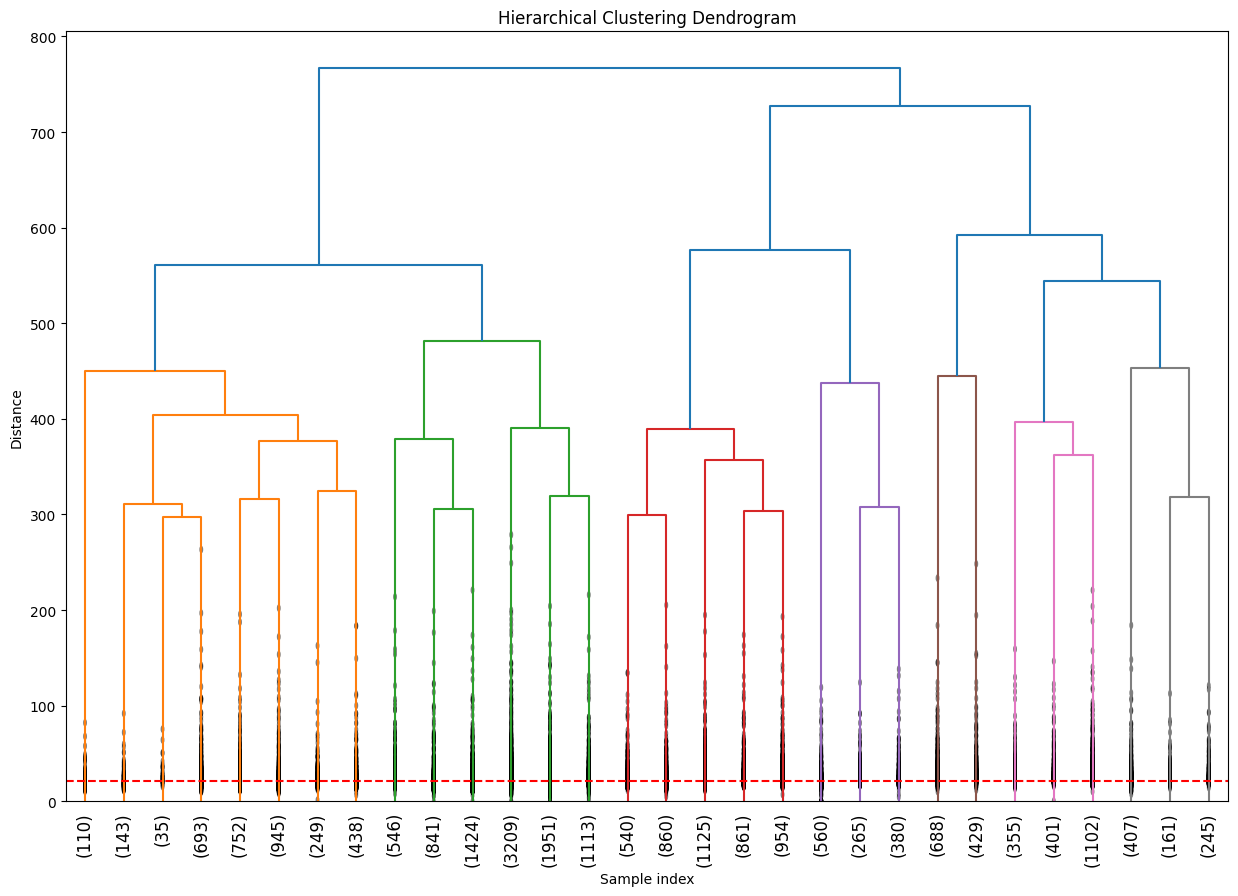

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(reduced_embeddings, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(
    Z,
    truncate_mode='lastp',  # truncate the dendrogram for better visibility
    p=30,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True    # to get a distribution impression in truncated branches
)
plt.axhline(y=21.159694601896057, color='r', linestyle='--')  # distance threshold
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

For DBSCAN (Density-Based Spatial Clustering of Applications with Noise), it uses eps (the maximum distance between two samples for one to be considered as in the neighborhood of the other) and min_samples (the number of samples in a neighborhood for a point to be considered as a core point) to determine the clusters.

In [28]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN
# can adjust `eps` and `min_samples`
dbscan = DBSCAN(eps=20.177118298003933, min_samples=15)

# Fit DBSCAN on the reduced embeddings
cluster_labels = dbscan.fit_predict(reduced_embeddings)

# Add cluster labels to the DataFrame
merged_df['cluster_label'] = cluster_labels

# Display the first few rows to verify
print(merged_df.head())

      video_id  start_time_seconds  end_time_seconds          labels  \
0  wqoOX8K8DEU                30.0              40.0      [396, 397]   
1  wqH6Sj_h948               120.0             130.0   [0, 441, 443]   
2  wq1098my4zA               130.0             140.0  [27, 137, 271]   
3  wqR7LHho-WE                10.0              20.0     [0, 22, 25]   
4  wq6Me-UUbSc               360.0             370.0           [413]   

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  ...  \
0         89        255         19         54        240        199  ...   
1         89         74        221        113         99        254  ...   
2        224        124        142        123        113        144  ...   
3        147        207        173        147        216         98  ...   
4         70         90        168         90        220         90  ...   

   feature_1271  feature_1272  feature_1273  feature_1274  feature_1275  \
0           152           255      

In [29]:
import numpy as np

# Count the number of unique clusters (excluding noise points labeled as -1)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

# Count the number of noise points (points labeled as -1)
num_noise_points = list(cluster_labels).count(-1)

print(f"Number of clusters: {num_clusters}")
print(f"Number of noise points: {num_noise_points}")

Number of clusters: 3
Number of noise points: 9763


In [30]:
import pandas as pd

cluster_counts = merged_df['cluster_label'].value_counts()
print(cluster_counts)

 0    11932
-1     9763
 1       55
 2       32
Name: cluster_label, dtype: int64


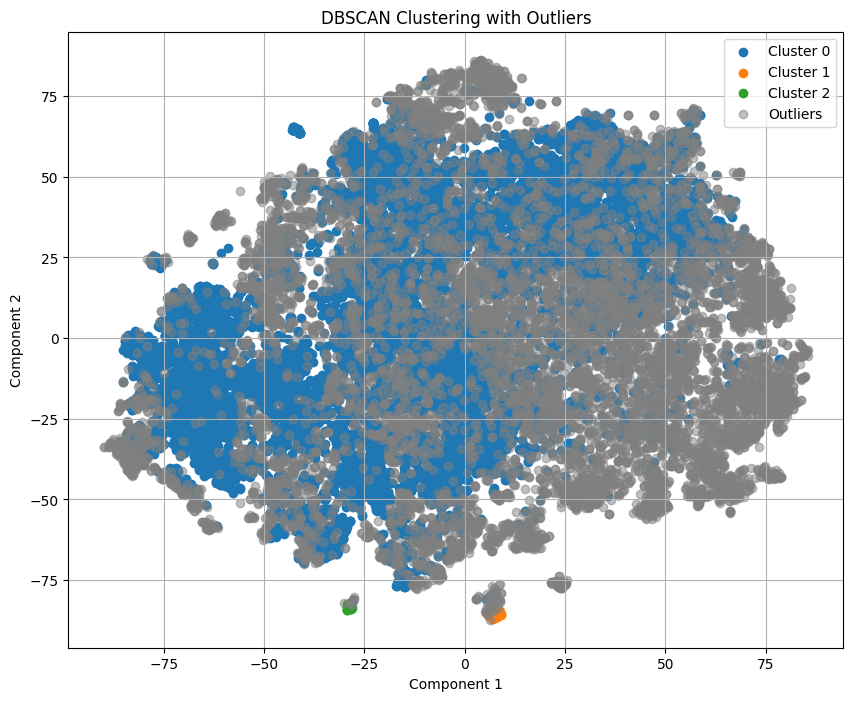

In [32]:
# cluster visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_clusters(embeddings_reduced, clusters, title):
    # Reduce dimensionality to 2 dimensions
    embeddings_2d = TSNE(n_components=2, random_state=42).fit_transform(embeddings_reduced)

    # Plot each cluster
    plt.figure(figsize=(10, 8))
    unique_clusters = set(clusters)

    for cluster in unique_clusters:
        if cluster == -1:
            plt.scatter(embeddings_2d[clusters == cluster, 0], embeddings_2d[clusters == cluster, 1],
                        color='grey', label='Outliers', alpha=0.5)
        else:
            plt.scatter(embeddings_2d[clusters == cluster, 0], embeddings_2d[clusters == cluster, 1],
                        label=f'Cluster {cluster}')

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_clusters(reduced_embeddings, cluster_labels, 'DBSCAN Clustering with Outliers')
